In [21]:
import pandas as pd
import subprocess 
import datetime 

load_new = False
try:
    data = pd.read_csv('data.csv')
except FileNotFoundError:
    load_new = True

data['date'] = pd.to_datetime(data['date'], format='%Y-%m-%d') #, data.dtypes

if datetime.datetime.now().date() - data.date.max().date() > datetime.timedelta(days = 1):
    load_new = True

if load_new:
    print('Download data:')
    subprocess.call(['wget', '-O', 'data.csv', 'http://cowid.netlify.com/data/full_data.csv'])

data = pd.read_csv('data.csv')
data['date'] = pd.to_datetime(data['date'], format='%Y-%m-%d') #, data.dtypes
print('Latest date: {}'.format(data.date.max().date()))
data.head()

Latest date: 2020-03-13


,date,location,new_cases,new_deaths,total_cases,total_deaths
0,2020-02-25,Afghanistan,NaN,NaN,1,NaN
1,2020-02-26,Afghanistan,0.0,NaN,1,NaN
2,2020-02-27,Afghanistan,0.0,NaN,1,NaN
3,2020-02-28,Afghanistan,0.0,NaN,1,NaN
4,2020-02-29,Afghanistan,0.0,NaN,1,NaN



Bad key "text.kerning_factor" on line 4 in
/home/topiko/.anaconda3/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution


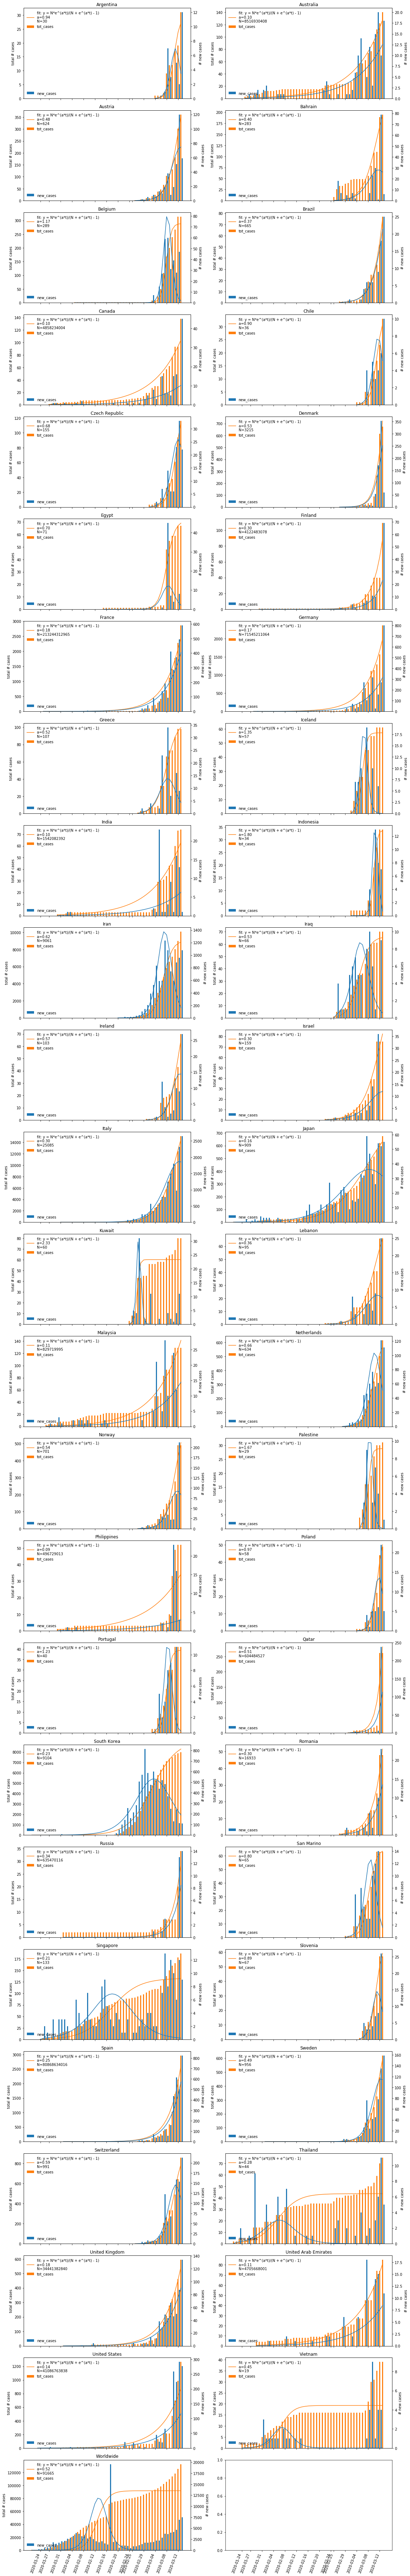

In [22]:
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import datetime 
import numpy as np

def set_ticks(times, ax):
    tickevery = 4
    #ticks = list(map(lambda x: x.strftime("%d %b"), times))[::tickevery]
    
    ticks = np.datetime_as_string(times, unit='D')[::tickevery]
    
    ax.set_xticks(times[::tickevery])
    ax.set_xticklabels(ticks, rotation = 70, ha="right")
    
def plot_bar_datetime(times, y, ax, label = None, align = 'right', color = None):
    
    if align == 'right':
        times = times + np.timedelta64(12, 'h')
        
    ax.bar(times, y, width = .4, label = label, color = color) #, align = align)
        

def fit_model(times, y_tot, first_case_date):
    
    
    exp_f_ = lambda t, N, a: N*np.exp(a*t)/(N + np.exp(a*t) - 1)
    #def exp_f_(times_, R, N):
    #    return np.exp(times_/R)*(N - y.cumsum())/N 
    
    times_ = (times - first_case_date)/np.timedelta64(1, 'D') # - np.timedelta64(1, 'D')
    
    N, a = curve_fit(exp_f_, times_, y_tot, [1000, 1])[0]
    
    
    model_totcases = exp_f_(times_, N, a) #model_newcases.cumsum()
    model_newcases = np.insert(np.diff(model_totcases), 0, 0)
    return model_newcases, model_totcases, N, a
    
    
def plot_line_datetime(times, y, ax, label = None, color = None):
    
    ax.plot(times, y, label = label, c = color)
    

def plot_fig1(mask, title, ax):
    times = data.loc[mask, 'date'].values.astype('datetime64[D]')
    y_new = data.loc[mask, 'new_cases'].values
    y_tot = data.loc[mask, 'total_cases'].values

    ax2 = ax.twinx()
    y_new = np.nan_to_num(y_new)

    plot_bar_datetime(times, y_new, ax2, 'new_cases', align = 'right', color = 'C0')
    plot_bar_datetime(times, y_tot, ax, 'tot_cases', align = 'left', color = 'C1')
    
    try:
        y_fit_newcases, y_fit_totcases, N, a = fit_model(times, y_tot, times[y_new != 0][0])
    except RuntimeError:
        return
    
    label = r'fit: y = N*e^(a*t)/(N + e^(a*t) - 1)' +  '\na={:.2f} \nN={:.0f}'.format(a, N)
    plot_line_datetime(times, y_fit_newcases, ax2, None, color = 'C0')
    plot_line_datetime(times, y_fit_totcases, ax, label, color = 'C1')
    
    if title is not None: ax.set_title(title)
    if label is not None: 
        ax2.legend(frameon = False, loc = 3)
        ax.legend(frameon = False, loc = 2)
    ax.set_ylabel('total # cases')
    ax2.set_ylabel('# new cases')



# select countries:
minncases = 30
remove_countries = ['International', 'China']
countries = []
for country in data.location.unique():
    if not data.loc[data.loc[:, 'location'] == country, 'total_cases'].max() > minncases:
        continue
    if country in remove_countries:
        continue
    
    countries.append(country)

#countries = ['South Korea']
ncols = 2
nrows = len(countries)//ncols + 1

figW, figH = ncols * 8, nrows*4
fig, axarr = plt.subplots(nrows, ncols, figsize = (figW, figH), sharex = True)

for country, ax in zip(countries, axarr.ravel()):
    mask = data.location == country
    plot_fig1(mask, country, ax)

times = data.date.unique()
for i in range(len(axarr[0])): set_ticks(times, axarr[-1, i])
    

plt.tight_layout()
plt.savefig('countries.pdf', facecolor=fig.get_facecolor(), transparent=True)
plt.savefig('countries.png', dpi = 200, facecolor=fig.get_facecolor(), transparent=True)
plt.show()

### Solve a spread model:

In [55]:
from sympy import *

t, a, N, C1 = symbols(r't a N C_1', real = True)
# y = total number of infected (t)
y = Function('y')(t)
y_ = Derivative(y, t)


eq = dsolve(a*y*(1-y/N) - y_, y, ics = {y.subs(t, 0):1})
eq

Eq(y(t), -N/(exp(C1*N - a*t) - 1))

#### use condition: y(0) == 1

In [56]:

yy = (-N/(exp(C1*N - a*t) - 1)).subs(C1, ln(1-N)/N)

(yy.diff(t) - a*yy*(1-yy/N)).simplify()
yy.simplify()

N*exp(a*t)/(N + exp(a*t) - 1)

#### Sanity check:

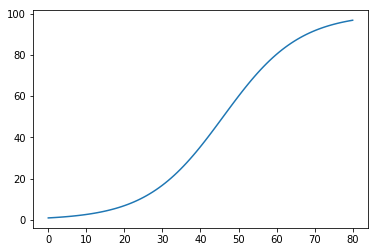

In [58]:
N = 100
a = .1

y_ = lambda t, N, a: N*np.exp(a*t)/(N + np.exp(a*t) - 1)

t = np.linspace(0,80,100)

plt.plot(t, y_(t, N, a))
plt.show()